In [1]:
import pandas as pd
import numpy as np


data = pd.read_csv("train.csv")

data.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Исследования фичей

<Axes: >

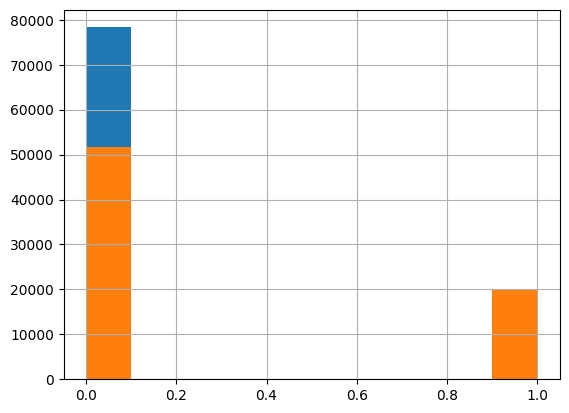

In [2]:
data[data["Gender"] == "Male"]["Exited"].hist()

data[data["Gender"] == "Female"]["Exited"].hist()

# Вывод: пол - важный признак

In [3]:
# Цель: для каждой страны отразить процентное соотношение вышедших и не вышедших

country = data.groupby(data["Geography"]).Exited.mean()
country.head()
print(dict(country))
# Идея: в country заменить страны на инфу о процентном содержании

{'France': 0.16528153691025846, 'Germany': 0.3789516268855112, 'Spain': 0.1721757379946428}


## Пошла тренировка

Какой план: 
1. Данные с num мы просто нормализуем
2. Категориальные данные мы или onehot, или label (label можно не по порядку, а как с идеей о странах) 
3. Кросс-валидацией прогоняем разные модели (с графиками precision-recall и ROC)
4. Обучаем

In [4]:
X = data.copy()

X.drop(columns=["id", "CustomerId", "Surname"], inplace=True)
y = X.pop("Exited")

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(132027, 10) (132027,)


In [6]:
from sklearn.base import TransformerMixin, BaseEstimator


class GeographyExitedPercent(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        pass
    def fit(self, X, y=None):
        data = pd.concat([X, y], axis=1) 
        self.regions = dict(data.groupby(data["Geography"]).Exited.apply(1 - mean()))
        return self
    def transform(self, X, y=None):
        X["Geography"] = X["Geography"].map(self.regions)
        return X

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

num_values = list(X.select_dtypes(exclude="object"))
obj_values = list(X.select_dtypes(include="object"))

print(num_values)

num_transformer = Pipeline(steps=[
    ("scaling", MinMaxScaler())
])

cat_transformer = ColumnTransformer([
    ("geography", GeographyExitedPercent(), ["Geography"]),
    ("gender", OrdinalEncoder(), ["Gender"])
])

data_prep = ColumnTransformer([
    ("num", num_transformer, num_values),
    ("cat", cat_transformer, obj_values)
])

prepared_train_X = data_prep.fit_transform(X_train, y_train)
prepared_train_X = pd.DataFrame(prepared_train_X, columns=X.columns)
prepared_train_X.head(10)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.882,0.202703,0.7,0.000000,0.333333,0.0,1.0,0.722081,0.172436,0.0
1,0.660,0.094595,0.0,0.606167,0.000000,1.0,1.0,0.656568,0.164897,1.0
2,0.708,0.351351,0.6,0.526341,0.333333,1.0,1.0,0.427090,0.377496,0.0
3,0.646,0.216216,0.7,0.327844,0.333333,1.0,0.0,0.547686,0.164897,1.0
4,0.348,0.378378,0.0,0.000000,0.000000,0.0,0.0,0.146896,0.164897,1.0
5,0.788,0.243243,0.3,0.536060,0.000000,1.0,0.0,0.377792,0.164897,1.0
6,0.626,0.256757,0.9,0.000000,0.000000,0.0,1.0,0.658131,0.164897,0.0
7,0.412,0.162162,0.9,0.000000,0.333333,1.0,0.0,0.880790,0.164897,1.0
8,0.698,0.162162,0.3,0.000000,0.333333,1.0,1.0,0.674397,0.164897,1.0
9,0.884,0.337838,0.8,0.672846,0.000000,0.0,0.0,0.703743,0.377496,0.0


In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

sgd = SGDClassifier()
kn = KNeighborsClassifier()
forest = RandomForestClassifier()

for model in (sgd, kn, forest):
    print(type(model).__name__,)
    pred = cross_val_predict(model, prepared_train_X, y_train, cv=3)
    print(f"Accuracy: {sum(pred == y_train) / len(y_train)}")
    print(confusion_matrix(y_train, pred))
    print("-------------------------------------------------------")


SGDClassifier
Accuracy: 0.8327917774394631
[[100471   3648]
 [ 18428   9480]]
-------------------------------------------------------
KNeighborsClassifier
Accuracy: 0.8439031410241844
[[97041  7078]
 [13531 14377]]
-------------------------------------------------------
RandomForestClassifier
Accuracy: 0.8579078521817507
[[98344  5775]
 [12985 14923]]
-------------------------------------------------------


In [10]:
# сравнение с тупым классификатором
print(f"Accuraccy: {sum(np.zeros(len(y_train)) == np.array(y_train)) / len(y_train)}")

Accuraccy: 0.7886189945995895


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

forest_pars = {
    "n_estimators": [100, 250, 1000],
    "max_depth": [None, 10, 100, 1000]
}

search = GridSearchCV(clone(forest), forest_pars, return_train_score=True)

search.fit(prepared_train_X, y_train)

search.best_estimator_


RandomForestClassifier(max_depth=10, n_estimators=1000)

## Тут уже готовимся к тесту 

In [32]:
prepared_X = data_prep.fit_transform(X, y)
forest = search.best_estimator_
forest.fit(prepared_X, y)

test_data = pd.read_csv("test.csv")

ids = test_data["id"]
test_data.drop(columns=["id", "CustomerId", "Surname"], inplace=True)
prepared_test_data = data_prep.transform(test_data)

In [33]:
final = forest.predict(prepared_test_data)
final = pd.Series(final)
output = pd.concat([ids, final], axis=1)
output.columns = ("id", "Exited")

In [34]:
output.to_csv("sample_submission.csv", index=False)